# STAT 201 Group 43 - Group Project Final Report

## Title: Determining whether a mutant strain of the nematode C. elegans slows its speed when in the presence of nutrients

In [19]:
# Please run this cell before continuing, installing packages if necessary.
library(tidyverse)
library(RColorBrewer)
library(tidymodels)
set.seed(2023)
options(repr.plot.width = 10, repr.plot.height = 6)
library(infer)

## Introduction

**Background:** Parkinson’s disease (PD) is a neurodegenerative disease that is most commonly associated with motor deficiencies. The symptoms of PD are thought to be due in part to depletion of the transmission of a neurotransmitter called dopamine (DA) between neurons in the brain. However, the genetic aspects of PD are not well understood. Encouragingly, in recent years, genome-wide association studies (GWASs) have rapidly uncovered genes that may be associated with PD. In an effort to characterize these genes to determine whether they are truly relevant to the pathology of PD, the nematode Caenorhabditis elegans can be studied due to its expression of functionally equivalent (orthologous) genes of many PD-associated genes. C. elegans is a model organism that is often used for neurogenetics experiments due to its genome and neural connections both being completely mapped out (add citations).

In this project, the effects of a mutation in the ortholog of a PD-associated gene, which renders the gene dysfunctional, will be examined.  Specifically, we will look at the effects on the basal slowing response (BSR), which is a dopamine-dependent slowing behaviour exhibited by *C. elegans* when in the presence of food (Sawin et al., 2000). A lack of slowing while on food indicates insufficient dopamine neurotransmission. CB1112 is the name of the mutant strain of *C. elegans* we will be using, as it is known to be deficient in dopamine.

**Our question:** Is there a difference in the mean speed of CB1112 worms on food and CB1112 worms not on food?

**Our dataset:** The dataset being used was acquired using the Rankin Lab’s Multi-Worm Tracker (Swierczek et al., 2011), which allows for the tracking of *C. elegans* behaviour. The dataset contains measurements of many variables throughout a 420-second experiment in which many CB1112 *C. elegans* were allowed to crawl either in the presence of food or in the absence of food. These variables include many behavioural and morphological measures, but the main variable that will be focused on is the speed at which the worms were crawling throughout the experiment.

## Methods and Results

In [20]:
# Load dataset
worm_data_raw <- read_csv('https://raw.githubusercontent.com/ben-westmore/stat-201-2022w2-group-43/main/N2_CB1112_baseline_output_12_11_2022.csv',
                          show_col_types = FALSE)

head(worm_data_raw)
nrow(worm_data_raw)

time_bin,worm,time,speed,x,y,angularspeed,pathlength,kink,bias,curve,dir,crab,length,midline,width,morphwidth,area,Strain
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
5,27,4.707,0.2312,23.73,29.97,10.880,0.07470,57.80,1,42.10,0,0.02003,0.7560,0.9690,0.2386,0.0867,0.0871,N2_Food
5,156,4.484,0.2195,36.94,25.75,7.300,0.13040,34.50,1,31.17,0,0.02087,0.9320,1.0360,0.1998,0.1648,0.1556,N2_Food
5,185,4.715,0.2563,25.62,24.98,34.660,0.08360,38.50,1,30.64,0,0.02118,0.7200,0.9310,0.2660,0.1404,0.1324,N2_Food
5,192,4.600,0.1354,28.47,19.23,5.484,0.06230,28.60,1,26.06,0,0.00981,0.5806,0.8200,0.1979,0.1378,0.1079,N2_Food
5,198,4.715,0.1797,24.28,30.77,3.680,0.05940,48.56,1,35.38,0,0.01484,0.7950,0.9263,0.1696,0.1467,0.1315,N2_Food
5,208,4.824,0.2135,27.83,25.23,5.035,0.05133,51.94,1,34.78,0,0.00853,0.8657,0.9717,0.2160,0.1774,0.1526,N2_Food


[1] 252756

In [21]:
# Select worm, speed, and Strain columns
# Filter observations with Strain "CB1112_Food" and "CB1112_NoFood"
# Calculate average speed of each worm

worm_data_cleaned <- worm_data_raw |>
    select(worm, speed, Strain) |>
    filter(Strain %in% c("CB1112_Food", "CB1112_NoFood")) |>
    group_by(Strain, worm) |>
    summarize(speed = mean(speed))

head(worm_data_cleaned)
nrow(worm_data_cleaned)

`summarise()` has grouped output by 'Strain'. You can override using the
`.groups` argument.


Strain,worm,speed
<chr>,<dbl>,<dbl>
CB1112_Food,1,0.2243345
CB1112_Food,2,0.1039276
CB1112_Food,3,0.1803790
CB1112_Food,4,0.2429433
CB1112_Food,6,0.2389154
CB1112_Food,7,0.1302114


[1] 932

In [22]:
# Rename the column "Strain" as "food_status"
colnames(worm_data_cleaned)[1]  <- "food_status"

# Change "CB1112_Food" to "Food", "CB1112_NoFood" to "NoFood"
worm_data_cleaned$food_status[worm_data_cleaned$food_status=="CB1112_Food"] <- "Food"
worm_data_cleaned$food_status[worm_data_cleaned$food_status=="CB1112_NoFood"] <- "NoFood"

head(worm_data_cleaned)
nrow(worm_data_cleaned)

d1 <- worm_data_cleaned %>% filter(food_status == "Food")
nrow(d1)
d2 <- worm_data_cleaned %>% filter(food_status == "NoFood")
nrow(d2)

food_status,worm,speed
<chr>,<dbl>,<dbl>
Food,1,0.2243345
Food,2,0.1039276
Food,3,0.1803790
Food,4,0.2429433
Food,6,0.2389154
Food,7,0.1302114


[1] 932

[1] 521

[1] 411

#### Table 1. Summary Statistics Across *Food* and *NoFood* Groups

In [23]:
# Create Table 1
summary <- worm_data_cleaned |>
    group_by(food_status) |>
    summarize(mean = mean(speed),
              median = median(speed),
              sd = sd(speed),
              n = n())
summary

food_status,mean,median,sd,n
<chr>,<dbl>,<dbl>,<dbl>,<int>
Food,0.1799004,0.1842810,0.04499372,521
NoFood,0.2018251,0.2052696,0.04383005,411


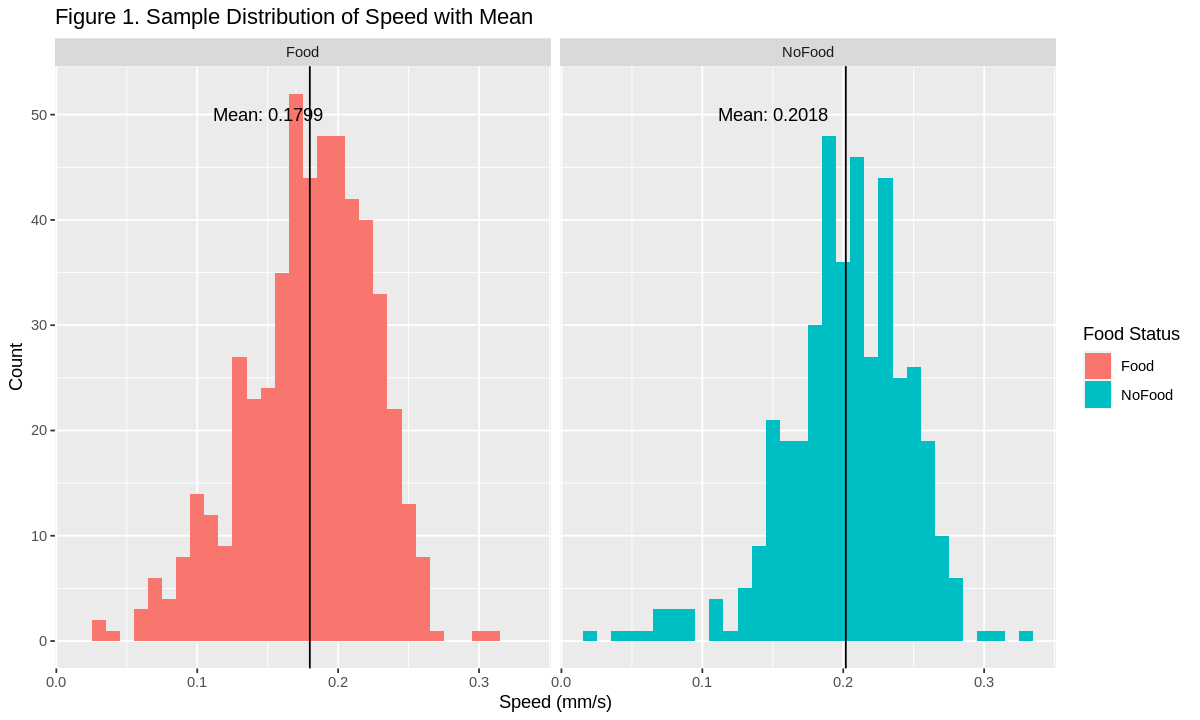

In [24]:
# Create histogram
hist <- worm_data_cleaned |>
    ggplot(aes(x = speed, fill = food_status)) +
    geom_histogram(binwidth = 0.01) +
    geom_vline(data = tibble(food_status = c("Food", "NoFood"), sample_mean = summary$mean), 
               aes(xintercept = sample_mean)) +
    geom_text(data = tibble(food_status = c("Food", "NoFood"), sample_mean=summary$mean),
              mapping = aes(x = 0.15, y = 50, label=paste("Mean:", round(sample_mean, 4)))) +
    facet_wrap(~food_status) +
    labs(x = "Speed (mm/s)",
         y = "Count",
         title = "Figure 1. Sample Distribution of Speed with Mean",
         fill = "Food Status")

hist

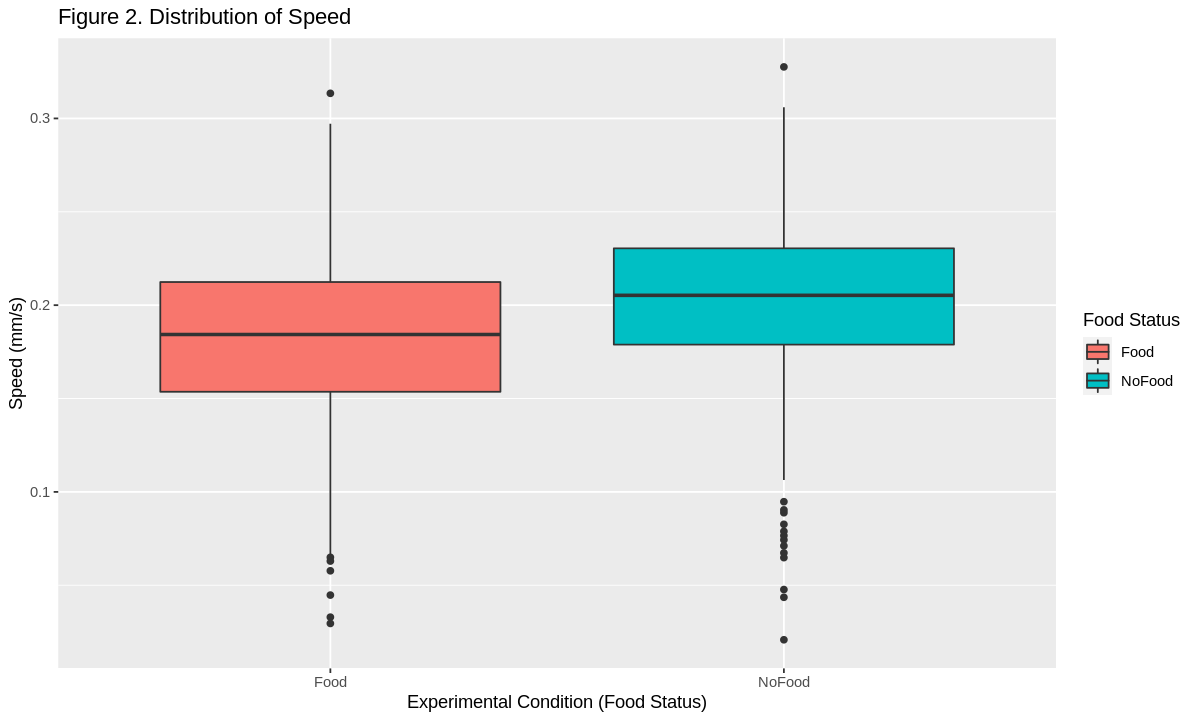

In [25]:
# Create boxplot
boxplot <- worm_data_cleaned |>
    ggplot() +
    geom_boxplot(aes(food_status, speed, fill = food_status)) +
    labs(x = "Experimental Condition (Food Status)",
         y = "Speed (mm/s)",
         title = "Figure 2. Distribution of Speed",
         fill = "Food Status")

boxplot

In [26]:
# two sample t-test between mean of speed of worms on food and worms not on food

# get data of worms on food
on_food <- worm_data_cleaned |>
            filter(food_status == "Food") |>
            select(speed) |>
            pull()

# get data of worms not on food
no_food <- worm_data_cleaned |>
            filter(food_status == "NoFood") |>
            select(speed) |>
            pull()

# compute two samplle t-test of worms on food and not on food and calculate confidence interval at 0.9
worm_t_test <- 
    tidy(
        t.test(x = on_food,
               y = no_food,
               conf.level = 0.9,
               alternative = "two.sided"))

# display the result
worm_t_test

Adding missing grouping variables: `food_status`
Adding missing grouping variables: `food_status`


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-0.02192477,0.1799004,0.2018251,-7.493812,1.613854e-13,890.0431,-0.02674216,-0.01710738,Welch Two Sample t-test,two.sided


In [27]:
# set seed
set.seed(2023)

# extract bootstrap distribution of worms on food and calculate the mean
onfood_bootstrap <- worm_data_cleaned |>
                filter(food_status == "Food") |>
                specify(response = speed) %>% 
                generate(type = "bootstrap", reps = 3000) %>% 
                calculate(stat = "mean")

# extract bootstrap distribution of worms not on food and calculate the mean
nofood_bootstrap <- worm_data_cleaned |>
                filter(food_status == "NoFood") |>
                specify(response = speed) %>% 
                generate(type = "bootstrap", reps = 3000) %>% 
                calculate(stat = "mean")

# display the head of data of bootstrap distribution of worms on food
head(onfood_bootstrap)

# display the head of data of bootstrap distribution of worms not on food
head(nofood_bootstrap)

replicate,stat
<int>,<dbl>
1,0.1804774
2,0.1839276
3,0.1819045
4,0.1805449
5,0.1813922
6,0.1813035


replicate,stat
<int>,<dbl>
1,0.2036373
2,0.1989341
3,0.2041286
4,0.2011692
5,0.2004116
6,0.2005447


In [28]:
# # Merge two tables
# bootstrap <- merge(nofood_bootstrap, onfood_bootstrap, by = "replicate")

# # Calculate the bootstrapping difference in mean
# bootstrap_diff <- bootstrap |>
# mutate(mean_diff = stat.x - stat.y) |>
# select(replicate, mean_diff)

# head(bootstrap_diff)

In [29]:
# # Null model 

# null <- bootstrap_diff |>
# mutate(stat = mean_diff + (0 - obs_mean_diff)) |>
# select(stat)

# head(null)

In [30]:
# # Visualize observed difference in mean on null distribution
# plot <- 
#     null %>%
#     ggplot() + 
#     geom_histogram(aes(x=stat)) +
#     xlab("difference in mean") +
#     geom_vline(aes(xintercept = obs_mean_diff))

# plot

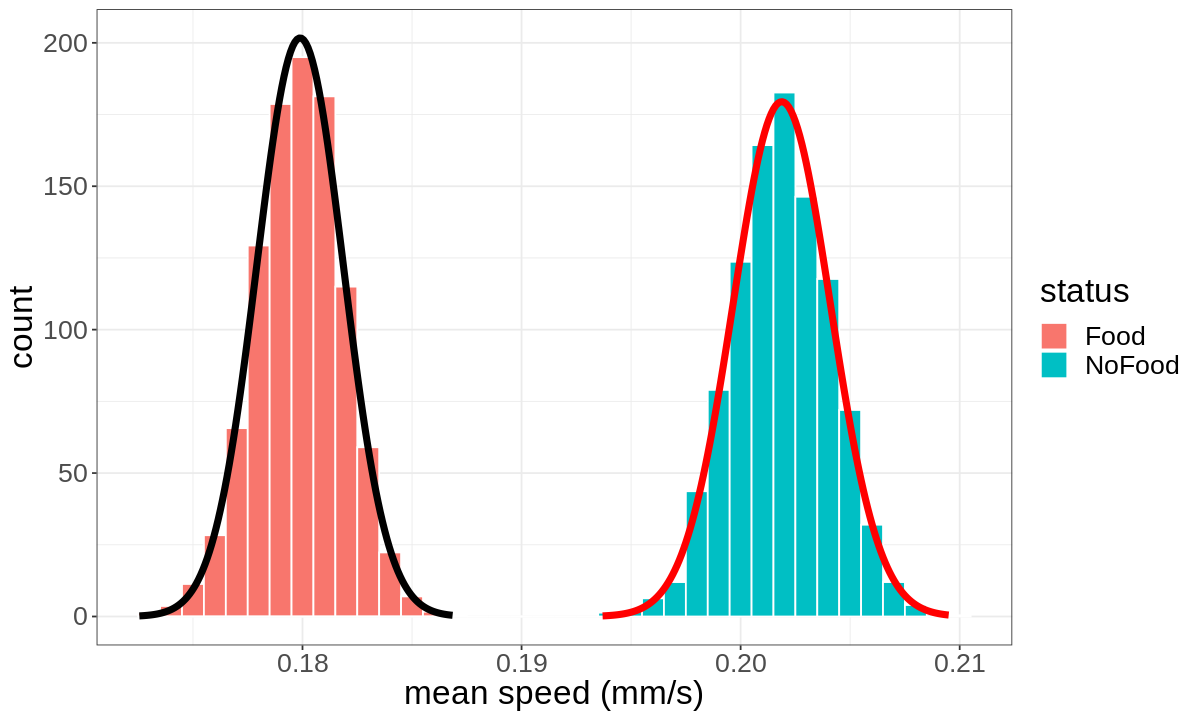

In [31]:
# combine two bootstrap distribution data
all_bootstrap <- bind_rows(onfood_bootstrap |> mutate(status = "Food"), nofood_bootstrap |> mutate(status = "NoFood"))

# visualize the bootstrapping data by histogram
bootstrap_dist <- all_bootstrap |>
                    group_by(replicate, status) |>
                    ggplot() +
                    geom_histogram(aes(x = stat, y = ..density.., fill = status), color = "white", binwidth = 0.001) +
                    geom_line(data = tibble(mean = seq(min(onfood_bootstrap$stat), max(onfood_bootstrap$stat), 0.0001),
                                           density = dnorm(mean, mean(onfood_bootstrap$stat), sd(onfood_bootstrap$stat))),
                             aes(x = mean,
                                 y = density),
                             color = "black", lwd = 2) +
                    geom_line(data = tibble(mean = seq(min(nofood_bootstrap$stat), max(nofood_bootstrap$stat), 0.0001),
                                           density = dnorm(mean, mean(nofood_bootstrap$stat), sd(nofood_bootstrap$stat))),
                             aes(x = mean,
                                 y = density),
                             color = "red", lwd = 2) +
                    xlab("mean speed (mm/s)") +
                    ylab("count") +
                    theme_bw() +
                    theme(text = element_text(size = 20))

bootstrap_dist

## Bootstrapping

Hypothesis Test:

$\bar{x}_{1}$: mean speed of NoFood group

$\bar{x}_{2}$: mean speed of Food group

$H_0$: $\bar{x}_{1}-\bar{x}_{2}=0$ vs $H_1$: $\bar{x}_{1}-\bar{x}_{2}\neq0$



Calculate observed test statistic `obs_mean_diff` as difference between NoFood and Food group.

In [32]:
# NoFood - Food
obs_mean_diff <- summary$mean[2]-summary$mean[1]
paste("obs_mean_diff =", obs_mean_diff)

[1] "obs_mean_diff = 0.0219247671690554"

`bootstrapping_model`: bootstrap 5000 samples and calculate difference in mean

In [42]:
set.seed(2023)

bootstrapping_model <- 
    worm_data_cleaned |>
    specify(formula = speed ~ food_status) |> 
    hypothesize(null = "independence") |> 
    generate(reps = 5000, type = "bootstrap") |>
    calculate(stat="diff in means", order = c("NoFood", "Food"))

head(bootstrapping_model)

replicate,stat
<int>,<dbl>
1,0.01885838
2,0.02004434
3,0.01816778
4,0.02241108
5,0.02170621
6,0.01950604


Shift the `bootstrapping_model` to have it centered at 0.

In [34]:
#null model
null_model <- bootstrapping_model |>
mutate(stat = stat + (0 - obs_mean_diff))

head(null_model)

replicate,stat
<int>,<dbl>
1,-0.0030663868
2,-0.0018804315
3,-0.0037569912
4,0.0004863147
5,-0.0002185620
6,-0.0024187279


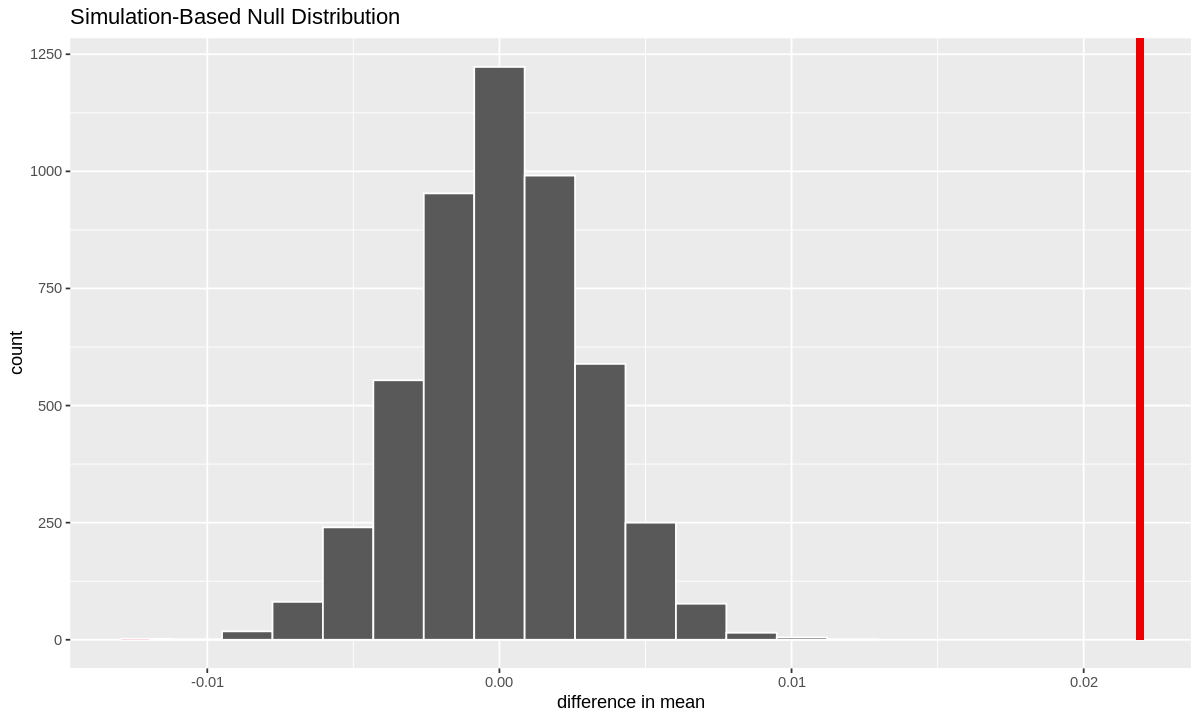

In [43]:
# Shade p_value on null distribution
result_plot <- 
    null_model %>%
    visualize() + 
    shade_p_value(obs_stat = obs_mean_diff, direction = "two.sided") +
xlab("difference in mean")

result_plot

Based on the plot, our observed test statistic 0.022 falls in the right extreme of the null model. 

In [44]:
# Calculate p_value

p_val <- 
    null_model%>% 
    get_p_value(obs_stat = obs_mean_diff, direction = "two.sided")

p_val

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


The p_value 0 sug
gests we reject our null hypothesis.

## CLT and Confidence Interval 

Three are three conditions that is needed to utilize the Central Limit Theorem Method
* All the samples taken should be independent from the population.
* To achieve the independence of the sample’s variables, the sample size must be less than 10% of the population size.
* Sample size must be large enough (at least 30) to be representative of the whole population.

Since we have met all three conditions abive, we can now compute the 95% confidence interval for the mean speed for worms with food and without food. We assign them to `clt_onfood_ci` and `clt_nofood_ci`

In [50]:
set.seed(50)

# We get sample for onfood worms and nofood worms respectively
sample_onfood <- worm_data_cleaned %>%
    filter(food_status == "Food") %>%
    rep_sample_n(size = 300, replace = F)

sample_nofood <- worm_data_cleaned %>%
    filter(food_status == "NoFood") %>%
    rep_sample_n(size = 300, replace = F)

# We compute the mean and standard error for each sample
onfood_sum <- sample_onfood %>%
    summarise(mean = mean(speed),
              se = sd(speed)/sqrt(nrow(sample_onfood)))

nofood_sum <- sample_nofood %>%
    summarise(mean = mean(speed),
              se = sd(speed)/sqrt(nrow(sample_nofood)))

# We obtain the 95% confidence interval using CLT 
clt_onfood_ci <- 
    tibble(
        lower_ci = qnorm(0.025, mean = onfood_sum$mean, sd = onfood_sum$se),
        upper_ci = qnorm(0.975, mean = onfood_sum$mean, sd = onfood_sum$se))
clt_onfood_ci

clt_nofood_ci <- 
    tibble(
        lower_ci = qnorm(0.025, mean = nofood_sum$mean, sd = nofood_sum$se),
        upper_ci = qnorm(0.975, mean = nofood_sum$mean, sd = nofood_sum$se))
clt_nofood_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.1763886,0.1866804


lower_ci,upper_ci
<dbl>,<dbl>
0.1965121,0.2062053


We can interpret two confidence intervals above as: 
* We are 95% confident that the mean speed of CB1112 worms with foods is between 0.1763886 and 0.1866804.
* We are 95% confident that the mean speed of CB1112 worms without food is between 0.1965121 and 0.2062053

### Comparing Bootstrapping 

## Discussion

## References

Sawin, E. R., Ranganathan, R., & Horvitz, H. R. (2000). C. elegans locomotory rate is modulated by the environment through a dopaminergic pathway and by experience through a serotonergic pathway. Neuron, 26(3), 619–631. https://doi.org/10.1016/s0896-6273(00)81199-x

Swierczek, N. A., Giles, A. C., Rankin, C. H., & Kerr, R. A. (2011). High-throughput behavioral analysis in C. elegans. Nature Methods, 8(7), 592–598. https://doi.org/10.1038/nmeth.1625